In [1]:
'''from google.colab import drive
drive.mount('/content/drive')'''

"from google.colab import drive\ndrive.mount('/content/drive')"

In [2]:
#!pip install catboost

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr

from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [4]:
#myfolder = "./"
myfolder = "../data/CMaps/"

# **Columns' names**

In [5]:
#Columns' names
'''
1)  unit number
2)	time, in cycles
3)	operational setting 1
4)	operational setting 2
5)	operational setting 3
6)	sensor measurement  1
7)	sensor measurement  2
...
26)	sensor measurement  21
'''
unitNames = ['UnitNumber']
timeCycles = ["TimeInCycles"]
operSets = ["OperSet"+str(i) for i in range(1,4)] # 1,2 et 3
sensorMes = ["SensorMes"+str(j) for j in range(1, 22)] # de 1 à 21
columnsNames = unitNames + timeCycles + operSets +sensorMes

# **Datasets loading**

In [6]:
def data_loading(x):
  train_path = myfolder + "train_"+ x +".txt"
  test_path = myfolder + "test_"+ x +".txt"
  rul_path = myfolder + "RUL_"+ x +".txt"
  train = pd.read_csv(train_path, delim_whitespace=True, names=columnsNames)
  test = pd.read_csv(test_path, delim_whitespace=True, names=columnsNames)
  rul = pd.read_csv(rul_path, delim_whitespace=True, names=["RUL_FD"])
  return train, test, rul

train_fd001, test_fd001, rul_fd001 = data_loading("FD001")
train_fd002, test_fd002, rul_fd002 = data_loading("FD002")
train_fd003, test_fd003, rul_fd003 = data_loading("FD003")
train_fd004, test_fd004, rul_fd004 = data_loading("FD004")

In [7]:
# Forcer l'affichage de toutes les colonnes
pd.set_option('display.max_columns', None)

train_fd004.head(3)

,UnitNumber,TimeInCycles,OperSet1,OperSet2,OperSet3,SensorMes1,SensorMes2,SensorMes3,SensorMes4,SensorMes5,SensorMes6,SensorMes7,SensorMes8,SensorMes9,SensorMes10,SensorMes11,SensorMes12,SensorMes13,SensorMes14,SensorMes15,SensorMes16,SensorMes17,SensorMes18,SensorMes19,SensorMes20,SensorMes21
0,1,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,3.91,5.70,137.36,2211.86,8311.32,1.01,41.69,129.78,2387.99,8074.83,9.3335,0.02,330,2212,100.0,10.62,6.3670
1,1,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,9.35,13.61,332.10,2323.66,8713.60,1.07,43.94,312.59,2387.73,8046.13,9.1913,0.02,361,2324,100.0,24.37,14.6552
2,1,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,3.91,5.69,138.18,2211.92,8306.69,1.01,41.66,129.62,2387.97,8066.62,9.4007,0.02,329,2212,100.0,10.48,6.4213


# **RUL column generation for train and test set**

In [8]:
def rul_train_generation(x):
  rul = pd.DataFrame(x.groupby('UnitNumber')['TimeInCycles'].max()).reset_index()
  rul.columns = ['UnitNumber', 'max']
  x = x.merge(rul, on=['UnitNumber'], how='left')
  x['RUL'] = x['max'] - x['TimeInCycles']
  x.drop('max', axis=1, inplace=True)
  return x

train_fd001 = rul_train_generation(train_fd001)
train_fd002 = rul_train_generation(train_fd002)
train_fd003 = rul_train_generation(train_fd003)
train_fd004 = rul_train_generation(train_fd004)

In [9]:
train_fd004.head(3)

,UnitNumber,TimeInCycles,OperSet1,OperSet2,OperSet3,SensorMes1,SensorMes2,SensorMes3,SensorMes4,SensorMes5,SensorMes6,SensorMes7,SensorMes8,SensorMes9,SensorMes10,SensorMes11,SensorMes12,SensorMes13,SensorMes14,SensorMes15,SensorMes16,SensorMes17,SensorMes18,SensorMes19,SensorMes20,SensorMes21,RUL
0,1,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,3.91,5.70,137.36,2211.86,8311.32,1.01,41.69,129.78,2387.99,8074.83,9.3335,0.02,330,2212,100.0,10.62,6.3670,320
1,1,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,9.35,13.61,332.10,2323.66,8713.60,1.07,43.94,312.59,2387.73,8046.13,9.1913,0.02,361,2324,100.0,24.37,14.6552,319
2,1,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,3.91,5.69,138.18,2211.92,8306.69,1.01,41.66,129.62,2387.97,8066.62,9.4007,0.02,329,2212,100.0,10.48,6.4213,318


In [10]:
def rul_test_generation(x, rul):

  rul["UnitNumber"] = rul.index + 1 # +1 pour que UnitNumber demarre de 1 au lieu de 0, car il s'agit du numero des moteur

  x = x.merge(rul, on=['UnitNumber'], how='left')

  max_cycle = pd.DataFrame(x.groupby('UnitNumber')['TimeInCycles'].max()).reset_index()
  max_cycle.columns = ['UnitNumber', 'max']
  x = x.merge(max_cycle, on=['UnitNumber'], how='left')
  x['RUL'] = x['RUL_FD'] + x['max'] - x['TimeInCycles']
  x.drop(['max', 'RUL_FD'], axis=1, inplace=True)

  return x

test_fd001 = rul_test_generation(test_fd001, rul_fd001)
test_fd002 = rul_test_generation(test_fd002, rul_fd002)
test_fd003 = rul_test_generation(test_fd003, rul_fd003)
test_fd004 = rul_test_generation(test_fd004, rul_fd004)

In [11]:
test_fd004.head(3)

,UnitNumber,TimeInCycles,OperSet1,OperSet2,OperSet3,SensorMes1,SensorMes2,SensorMes3,SensorMes4,SensorMes5,SensorMes6,SensorMes7,SensorMes8,SensorMes9,SensorMes10,SensorMes11,SensorMes12,SensorMes13,SensorMes14,SensorMes15,SensorMes16,SensorMes17,SensorMes18,SensorMes19,SensorMes20,SensorMes21,RUL
0,1,1,20.0072,0.700,100.0,491.19,606.67,1481.04,1227.81,9.35,13.60,332.52,2323.67,8704.98,1.07,43.83,313.03,2387.78,8048.98,9.2229,0.02,362,2324,100.00,24.31,14.7007,251
1,1,2,24.9984,0.620,60.0,462.54,536.22,1256.17,1031.48,7.05,9.00,174.46,1915.21,7999.94,0.93,36.11,163.61,2028.09,7863.46,10.8632,0.02,306,1915,84.93,14.36,8.5748,250
2,1,3,42.0000,0.842,100.0,445.00,549.23,1340.13,1105.88,3.91,5.69,137.34,2211.93,8305.38,1.01,41.52,129.98,2387.95,8071.13,9.3960,0.02,328,2212,100.00,10.39,6.4365,249


# **RANDOM SAMPLE SELECTION**

In [12]:
'''element_counts = test_fd002[test_fd002['UnitNumber']==1]
len(element_counts)'''

"element_counts = test_fd002[test_fd002['UnitNumber']==1]\nlen(element_counts)"

In [13]:
import random

def selection_aleatoire(df, sample_size, rand_state):
    unique_values = df["UnitNumber"].unique()
    selected_rows = []
    for value in unique_values:
        rows = df[df["UnitNumber"] == value]
        if len(rows) < sample_size : # si la taille de l'echantillon donnée est superieur au nombre total de ligne pour un moteur, reinitialiser la valeur
            sample_size = len(rows)
        random_sample = rows.sample(n=sample_size, random_state = rand_state)  # Sélectionne 50 lignes aléatoires
        selected_rows.append(random_sample)
    result = pd.concat(selected_rows)
    return result

# **Data normalization**

In [14]:
def normalised_df(train, test):

  from sklearn.preprocessing import MinMaxScaler

  # Instancier l'objet MinMaxScaler pour normaliser les données
  scaler = MinMaxScaler()

  # Normaliser train
  train_scaled = scaler.fit_transform(train)
  train_df = pd.DataFrame(train_scaled)

  # Normaliser test
  test_scaled = scaler.fit_transform(test)
  test_df = pd.DataFrame(test_scaled)


  train_df.columns = train.columns
  test_df.columns = test.columns
    
  return train_df, test_df

# **Data splitting**

In [15]:
def data_split(train, test):

  # data split
  X_train = train.drop('RUL', axis=1)
  Y_train = train['RUL']
  X_test = test.drop('RUL', axis=1)
  Y_test = test['RUL']
    
  return X_train, Y_train, X_test, Y_test


# **Columns to drop**

In [16]:
def drop_columns(train, test, wich):
    if wich == 1:
        operSets_to_drop = ["OperSet"+str(i) for i in [1, 2]] # 1 et 2
        sensorMes_to_drop = ["SensorMes"+str(j) for j in [3, 6, 8, 9, 13, 14]]
        cols_to_drop = operSets_to_drop + sensorMes_to_drop
    elif wich == 2:
        operSets_to_drop = ["OperSet"+str(i) for i in range(1,4)] # 1,2 et 3
        sensorMes_to_drop = ["SensorMes"+str(j) for j in [1, 5, 10, 18, 19]]
        cols_to_drop = operSets_to_drop + sensorMes_to_drop
    elif wich == 3:
        operSets_to_drop = ["OperSet"+str(i) for i in [1, 2]] # 1 et 2
        sensorMes_to_drop = ["SensorMes"+str(j) for j in [6, 7, 10, 12, 15, 20, 21]]
        cols_to_drop = operSets_to_drop + sensorMes_to_drop
    elif wich == 4:
        operSets_to_drop = ["OperSet"+str(i) for i in range(1,4)] # 1,2 et 3
        sensorMes_to_drop = ["SensorMes"+str(j) for j in [1, 5, 6, 7, 12, 15, 18, 19, 20, 21]]
        cols_to_drop = operSets_to_drop + sensorMes_to_drop
        
    # drop columns 
    drop_cols=True
    if(drop_cols == True):
      train = train.drop(cols_to_drop, axis=1)
      test = test.drop(cols_to_drop, axis=1)
    return train, test

# **The GRU model**

# One Layer

In [40]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

def my_gru(train_fd, test_fd):

    # Normaliser les données
    scaler = MinMaxScaler()

    train = scaler.fit_transform(train_fd)
    test = scaler.transform(test_fd)

    # Préparer les données pour le modèle GRU
    train_X = train[:,:-1]
    train_y = train[:,-1]

    test_X = test[:,:-1]
    test_y = test[:,-1]

    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

    # Créer le modèle GRU
    model = Sequential()
    model.add(GRU(50, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))

    # Compiler le modèle avec une optimisation
    model.compile(loss='mae', optimizer=Adam(), metrics=['mse'])

    # Entraîner le modèle
    history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=0, shuffle=False)


    # Afficher l'erreur d'entraînement et de validation sur une courbe
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Test')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    
    # Calculer et afficher RMSE
    rmse_train = np.sqrt(history.history['mse'])
    rmse_test = np.sqrt(history.history['val_mse'])
    plt.plot(rmse_train, label='Train RMSE')
    plt.plot(rmse_test, label='Test RMSE')
    plt.title('Root Mean Squared Error')
    plt.ylabel('RMSE')
    plt.xlabel('# Epoch')
    plt.legend(loc='upper left')
    plt.show()

    scores = model.evaluate(train_X, train_y, verbose=1, batch_size=200)
    print('Train RMSE: {}'.format(np.sqrt(scores[1])))
    
    scores_test = model.evaluate(test_X, test_y, verbose=200)
    print('Test RMSE: {}'.format(np.sqrt(scores_test[1])))
    
    y_pred_test = model.predict(test_X, verbose=200)
    plt.figure(figsize=(10,5))
    plt.plot(y_pred_test, color='red', label='Prediction')
    plt.plot(test_y, color='blue', label='Ground Truth')
    plt.ylabel("RUL")
    plt.xlabel("Unit Number")
    
    print('MAE: ',mean_absolute_error(test_y, y_pred_test))
    print('RMSE: ',np.sqrt(mean_squared_error(test_y, y_pred_test)))

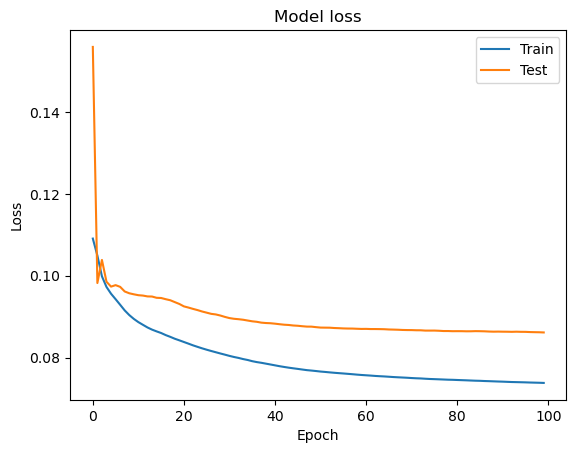

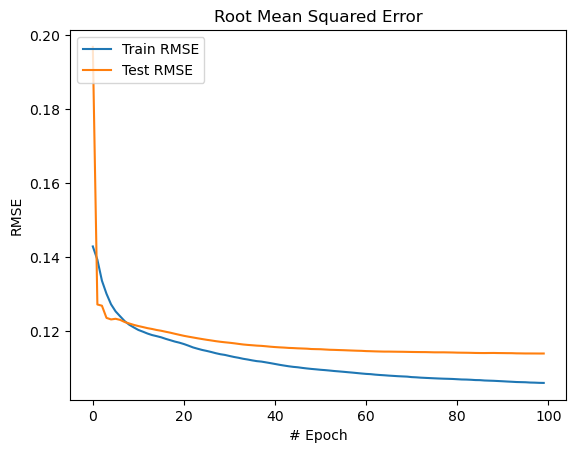

104/104 [==============================] - 0s 3ms/step - loss: 0.0726 - mse: 0.0105
Train RMSE: 0.10268738781724956
Test RMSE: 0.11388243038298923
MAE:  0.08616788223204216
RMSE:  0.1138824437913559


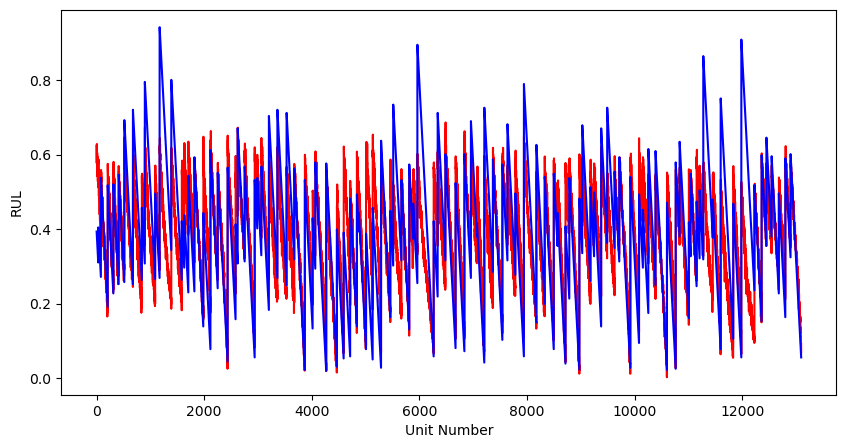

In [41]:
my_gru(train_fd001, test_fd001)

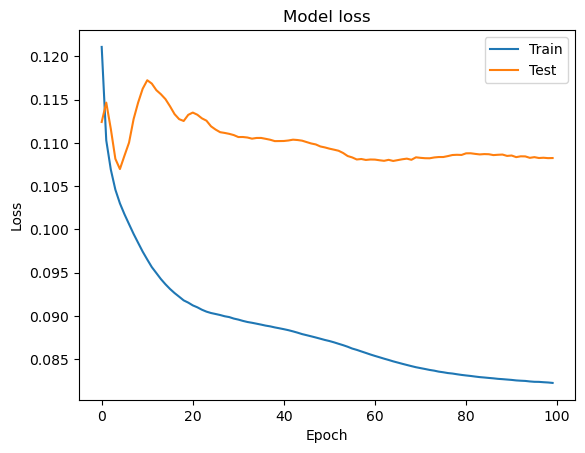

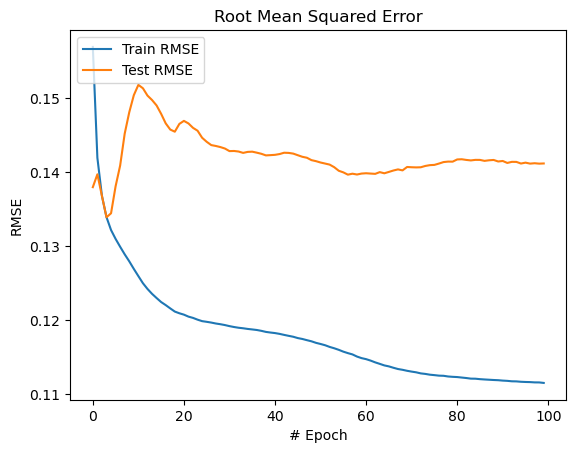

269/269 [==============================] - 1s 3ms/step - loss: 0.0815 - mse: 0.0132
Train RMSE: 0.11471864087840777
Test RMSE: 0.1411878461411359
MAE:  0.108242848392049
RMSE:  0.1411878524306502


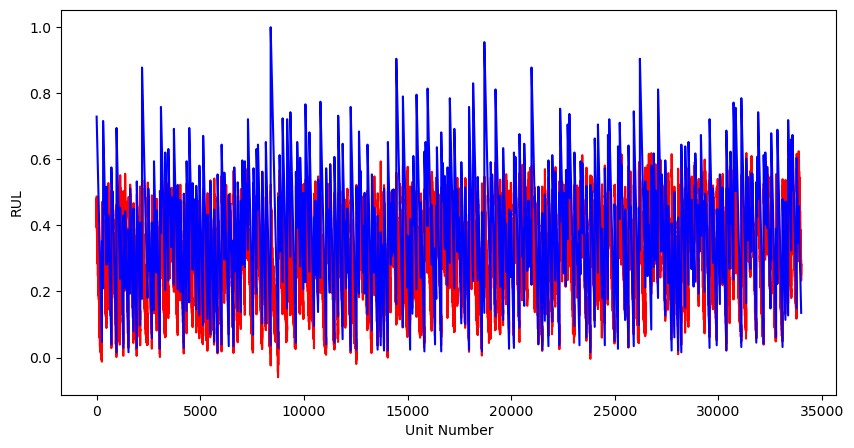

In [42]:
my_gru(train_fd002, test_fd002)

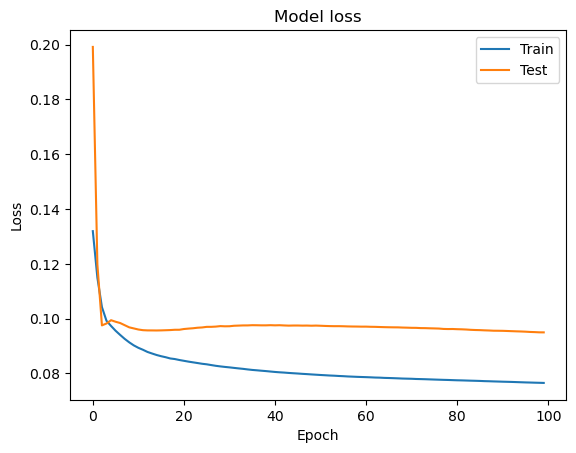

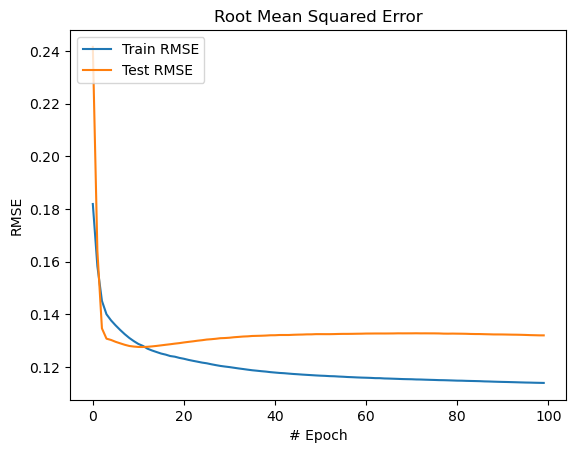

124/124 [==============================] - 0s 3ms/step - loss: 0.0748 - mse: 0.0121
Train RMSE: 0.10988971815978532
Test RMSE: 0.13203504855994966
MAE:  0.09499395966226747
RMSE:  0.13203502089303168


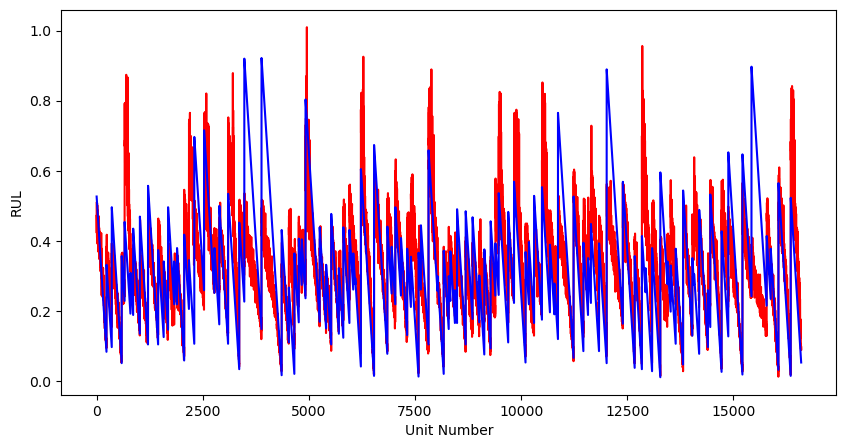

In [43]:
my_gru(train_fd003, test_fd003)

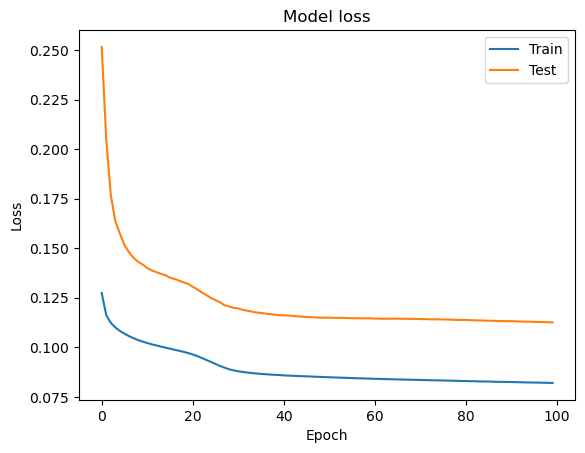

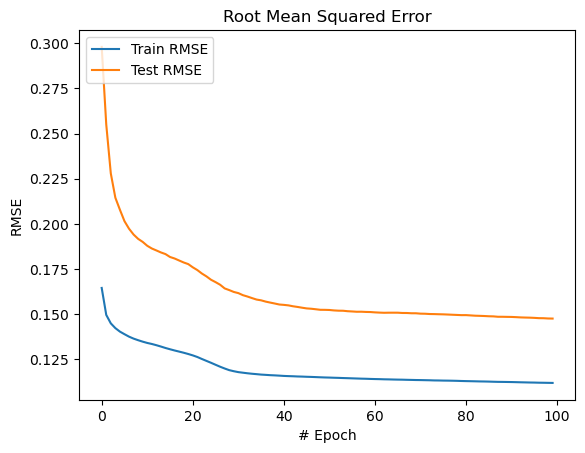

307/307 [==============================] - 1s 3ms/step - loss: 0.0826 - mse: 0.0122
Train RMSE: 0.11035413654667378
Test RMSE: 0.1476370347351819
MAE:  0.11257958719675161
RMSE:  0.14763700108158234


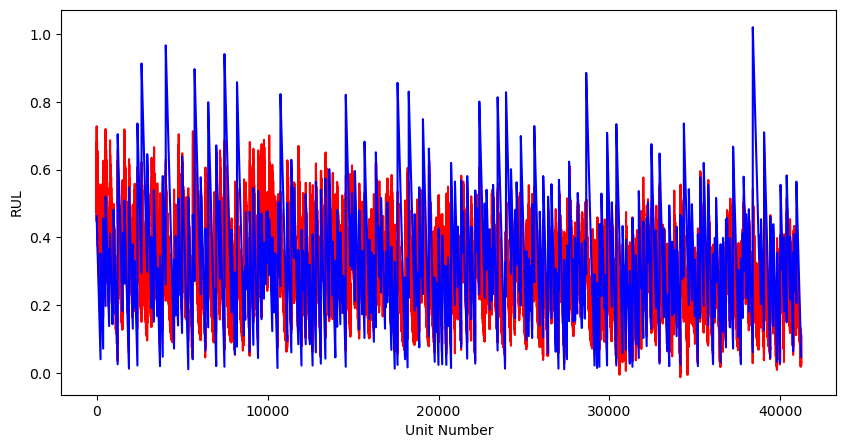

In [44]:
my_gru(train_fd004, test_fd004)

# Two Layers

In [45]:
def my_gru(train_fd, test_fd):

    # Normaliser les données
    scaler = MinMaxScaler()

    train = scaler.fit_transform(train_fd)
    test = scaler.transform(test_fd)

    # Préparer les données pour le modèle GRU
    train_X = train[:,:-1]
    train_y = train[:,-1]

    test_X = test[:,:-1]
    test_y = test[:,-1]

    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

    # Créer le modèle GRU
    model = Sequential()
    model.add(GRU(units=100, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dropout(0.2))
    model.add(GRU(units=100, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.add(Activation("relu"))

    # Compiler le modèle avec une optimisation
    model.compile(loss='mae', optimizer=Adam(), metrics=['mse'])

    # Entraîner le modèle
    history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=0, shuffle=False)


    # Afficher l'erreur d'entraînement et de validation sur une courbe
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Test')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    
    # Calculer et afficher RMSE
    rmse_train = np.sqrt(history.history['mse'])
    rmse_test = np.sqrt(history.history['val_mse'])
    plt.plot(rmse_train, label='Train RMSE')
    plt.plot(rmse_test, label='Test RMSE')
    plt.title('Root Mean Squared Error')
    plt.ylabel('RMSE')
    plt.xlabel('# Epoch')
    plt.legend(loc='upper left')
    plt.show()

    scores = model.evaluate(train_X, train_y, verbose=1, batch_size=200)
    print('Train RMSE: {}'.format(np.sqrt(scores[1])))
    
    scores_test = model.evaluate(test_X, test_y, verbose=200)
    print('Test RMSE: {}'.format(np.sqrt(scores_test[1])))
    
    y_pred_test = model.predict(test_X, verbose=200)
    plt.figure(figsize=(10,5))
    plt.plot(y_pred_test, color='red', label='Prediction')
    plt.plot(test_y, color='blue', label='Ground Truth')
    plt.ylabel("RUL")
    plt.xlabel("Unit Number")
    
    print('MAE: ',mean_absolute_error(test_y, y_pred_test))
    print('RMSE: ',np.sqrt(mean_squared_error(test_y, y_pred_test)))

410/410 [==============================] - 2s 3ms/step
MAE: 0.08483934798488897
RMSE: 0.1145059167156198


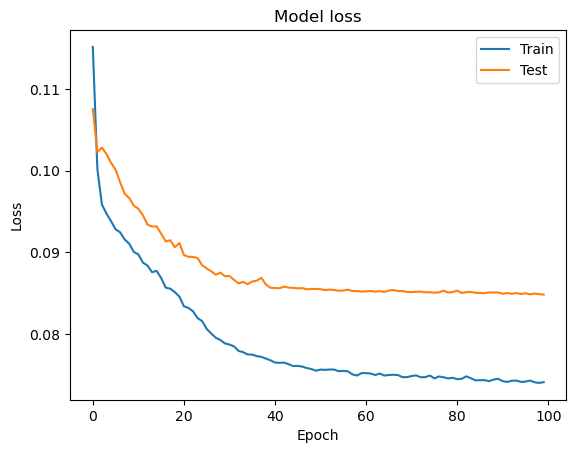

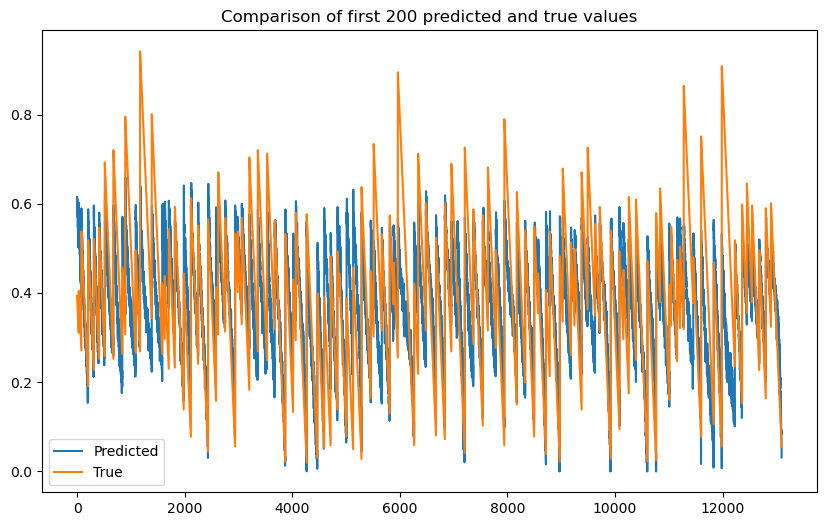

In [46]:
my_gru2(train_fd001, test_fd001)

1063/1063 [==============================] - 5s 3ms/step
MAE: 0.09661317201160229
RMSE: 0.12593765754398997


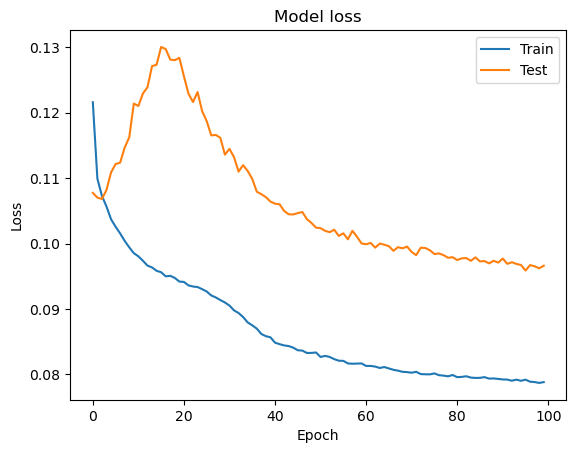

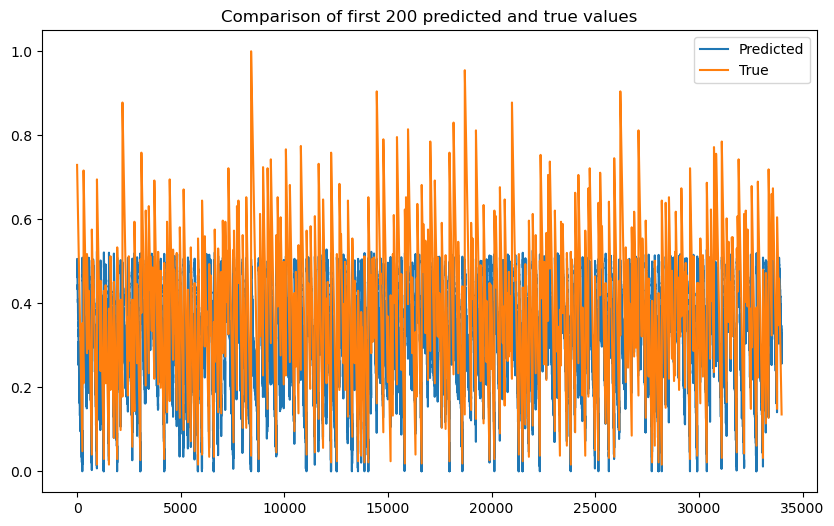

In [47]:
my_gru2(train_fd002, test_fd002)

519/519 [==============================] - 3s 3ms/step
MAE: 0.09083803602165597
RMSE: 0.12660889634693823


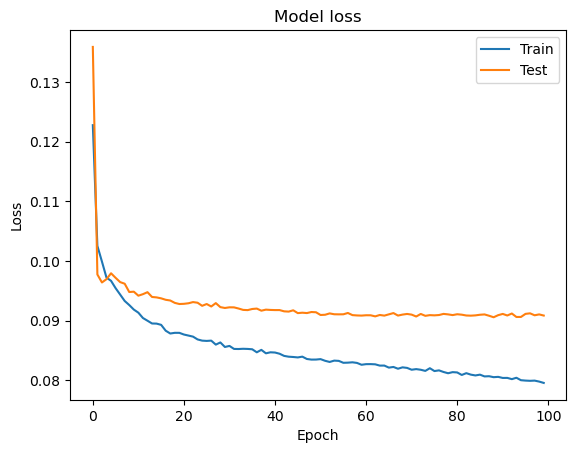

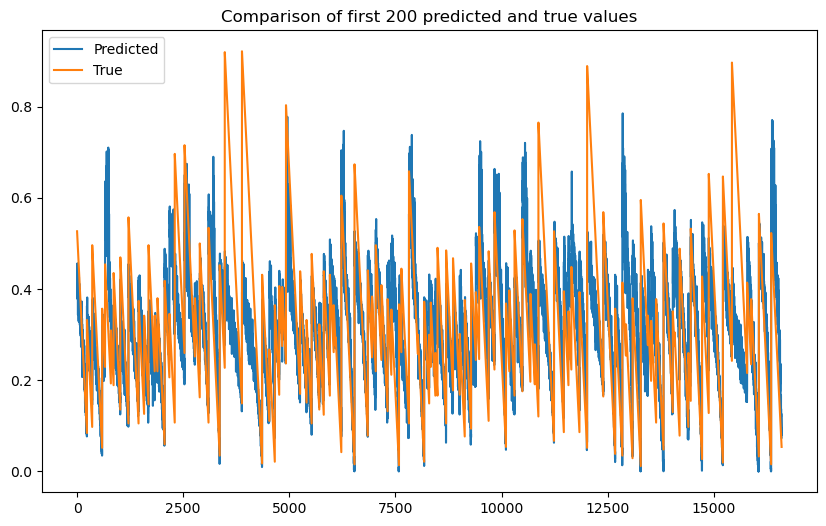

In [48]:
my_gru2(train_fd003, test_fd003)

1288/1288 [==============================] - 6s 3ms/step
MAE: 0.10637196985843493
RMSE: 0.14140193459744502


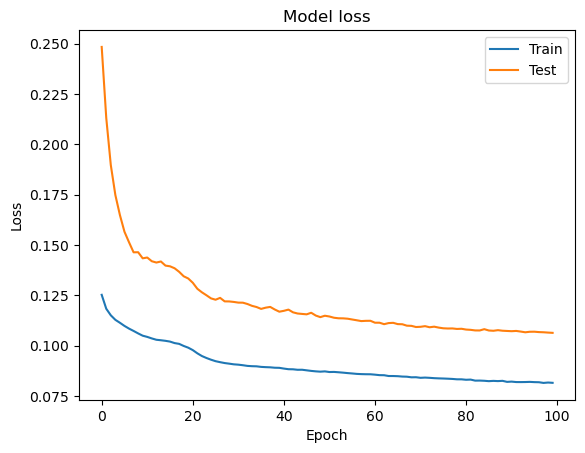

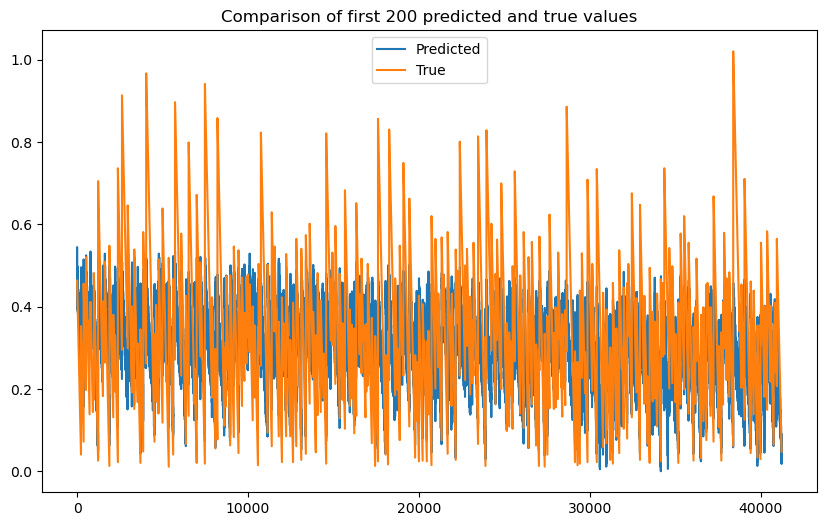

In [49]:
my_gru2(train_fd004, test_fd004)

# Two Layers Early Stopping No1

In [30]:
def my_gru3(train_fd, test_fd):

    # Normaliser les données
    scaler = MinMaxScaler()

    train = scaler.fit_transform(train_fd)
    test = scaler.transform(test_fd)

    # Préparer les données pour le modèle GRU
    train_X = train[:,:-1]
    train_y = train[:,-1]

    test_X = test[:,:-1]
    test_y = test[:,-1]

    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

    # Créer le modèle GRU
    model = Sequential()
    model.add(GRU(units=100, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dropout(0.2))
    model.add(GRU(units=100, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.add(Activation("relu"))

    # Compiler le modèle avec une optimisation
    model.compile(loss='mae', optimizer=Adam(), metrics=['mse'])

    # Entraîner le modèle
    history = model.fit(train_X, train_y, epochs=100, batch_size=32, validation_split=0.1, verbose=1,
          callbacks=[EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')])

    # Afficher l'erreur d'entraînement et de validation sur une courbe
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Test')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    
    # Calculer et afficher RMSE
    rmse_train = np.sqrt(history.history['mse'])
    rmse_test = np.sqrt(history.history['val_mse'])
    plt.plot(rmse_train, label='Train RMSE')
    plt.plot(rmse_test, label='Test RMSE')
    plt.title('Root Mean Squared Error')
    plt.ylabel('RMSE')
    plt.xlabel('# Epoch')
    plt.legend(loc='upper left')
    plt.show()

    scores = model.evaluate(train_X, train_y, verbose=1, batch_size=200)
    print('Train RMSE: {}'.format(np.sqrt(scores[1])))
    
    scores_test = model.evaluate(test_X, test_y, verbose=200)
    print('Test RMSE: {}'.format(np.sqrt(scores_test[1])))
    
    y_pred_test = model.predict(test_X, verbose=200)
    plt.figure(figsize=(10,5))
    plt.plot(y_pred_test, color='red', label='Prediction')
    plt.plot(test_y, color='blue', label='Ground Truth')
    plt.ylabel("RUL")
    plt.xlabel("Unit Number")
    
    print('MAE: ',mean_absolute_error(test_y, y_pred_test))
    print('RMSE: ',np.sqrt(mean_squared_error(test_y, y_pred_test)))

Epoch 1/100
581/581 [==============================] - 13s 9ms/step - loss: 0.0820 - mse: 0.0128 - val_loss: 0.1314 - val_mse: 0.0259
Epoch 2/100
581/581 [==============================] - 4s 7ms/step - loss: 0.0748 - mse: 0.0109 - val_loss: 0.1263 - val_mse: 0.0236
Epoch 3/100
581/581 [==============================] - 4s 7ms/step - loss: 0.0710 - mse: 0.0102 - val_loss: 0.1196 - val_mse: 0.0218
Epoch 4/100
581/581 [==============================] - 5s 8ms/step - loss: 0.0691 - mse: 0.0099 - val_loss: 0.1244 - val_mse: 0.0302
Epoch 5/100
581/581 [==============================] - 4s 7ms/step - loss: 0.0685 - mse: 0.0098 - val_loss: 0.1166 - val_mse: 0.0228
Epoch 6/100
581/581 [==============================] - 4s 7ms/step - loss: 0.0675 - mse: 0.0097 - val_loss: 0.1152 - val_mse: 0.0233
Epoch 7/100
581/581 [==============================] - 5s 8ms/step - loss: 0.0669 - mse: 0.0095 - val_loss: 0.1112 - val_mse: 0.0213
Epoch 8/100
581/581 [==============================] - 4s 8ms/step -

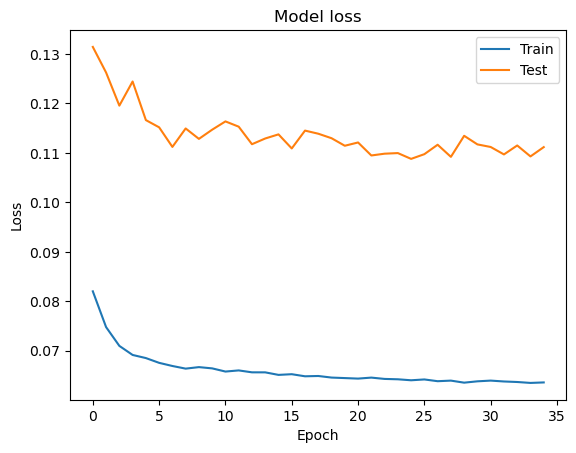

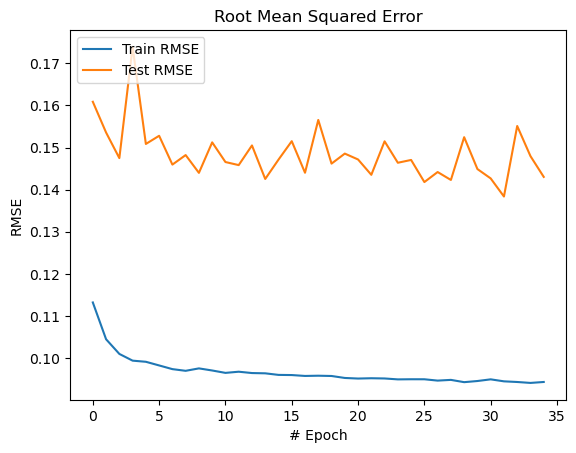

104/104 [==============================] - 0s 4ms/step - loss: 0.0663 - mse: 0.0096
Train RMSE: 0.09793453144468886
Test RMSE: 0.11103084676627996
MAE:  0.08395489572868148
RMSE:  0.11103084929337682


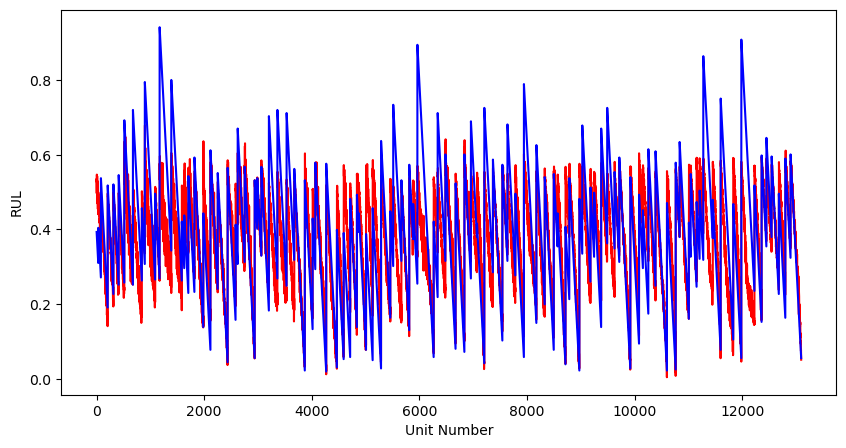

In [31]:
my_gru3(train_fd001, test_fd001)

Epoch 1/100
1512/1512 [==============================] - 20s 7ms/step - loss: 0.0955 - mse: 0.0163 - val_loss: 0.1132 - val_mse: 0.0196
Epoch 2/100
1512/1512 [==============================] - 10s 6ms/step - loss: 0.0884 - mse: 0.0142 - val_loss: 0.1099 - val_mse: 0.0191
Epoch 3/100
1512/1512 [==============================] - 10s 6ms/step - loss: 0.0861 - mse: 0.0137 - val_loss: 0.1144 - val_mse: 0.0215
Epoch 4/100
1512/1512 [==============================] - 10s 7ms/step - loss: 0.0840 - mse: 0.0131 - val_loss: 0.1062 - val_mse: 0.0189
Epoch 5/100
1512/1512 [==============================] - 9s 6ms/step - loss: 0.0814 - mse: 0.0125 - val_loss: 0.1000 - val_mse: 0.0167
Epoch 6/100
1512/1512 [==============================] - 9s 6ms/step - loss: 0.0780 - mse: 0.0116 - val_loss: 0.0965 - val_mse: 0.0161
Epoch 7/100
1512/1512 [==============================] - 10s 6ms/step - loss: 0.0762 - mse: 0.0112 - val_loss: 0.0991 - val_mse: 0.0179
Epoch 8/100
1512/1512 [===========================

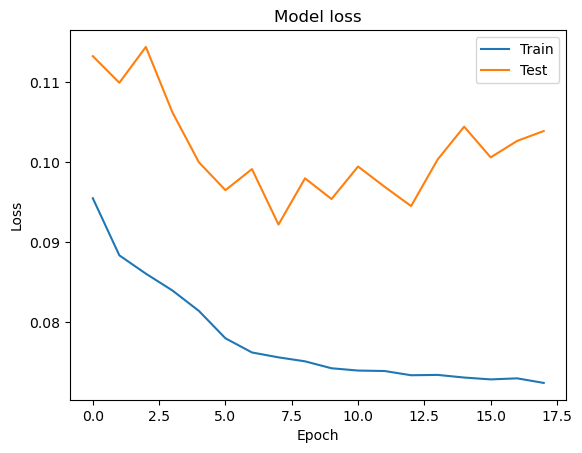

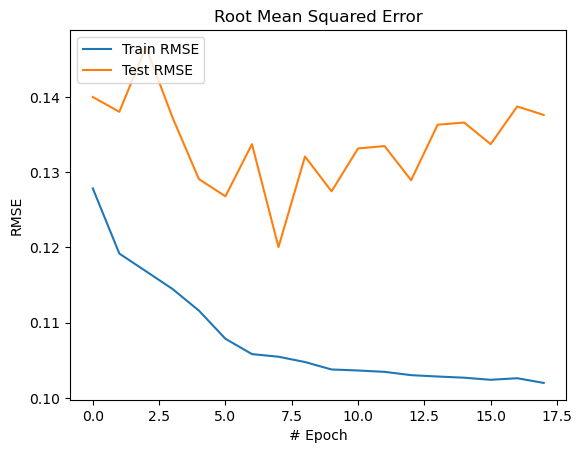

269/269 [==============================] - 3s 4ms/step - loss: 0.0738 - mse: 0.0113
Train RMSE: 0.1061838947142141
Test RMSE: 0.13151978626173813
MAE:  0.1011875238250306
RMSE:  0.13151980665200882


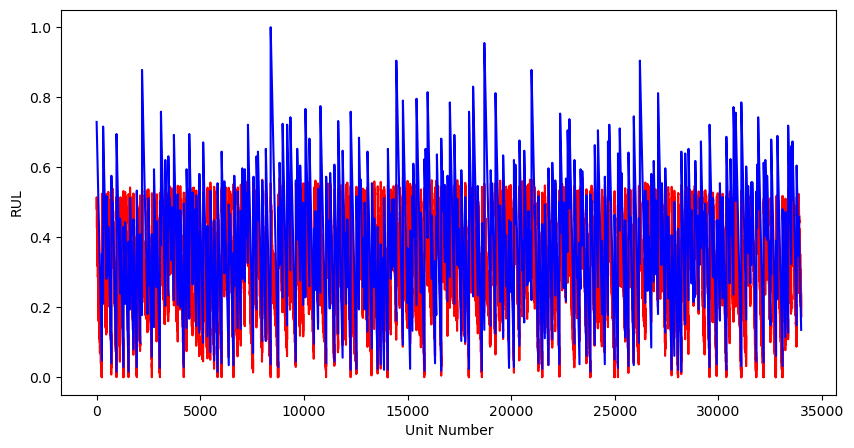

In [32]:
my_gru3(train_fd002, test_fd002)

Epoch 1/100
696/696 [==============================] - 14s 8ms/step - loss: 0.0883 - mse: 0.0159 - val_loss: 0.1302 - val_mse: 0.0378
Epoch 2/100
696/696 [==============================] - 4s 6ms/step - loss: 0.0792 - mse: 0.0122 - val_loss: 0.1123 - val_mse: 0.0316
Epoch 3/100
696/696 [==============================] - 4s 6ms/step - loss: 0.0766 - mse: 0.0116 - val_loss: 0.1271 - val_mse: 0.0393
Epoch 4/100
696/696 [==============================] - 4s 6ms/step - loss: 0.0753 - mse: 0.0114 - val_loss: 0.1125 - val_mse: 0.0325
Epoch 5/100
696/696 [==============================] - 4s 6ms/step - loss: 0.0731 - mse: 0.0110 - val_loss: 0.1003 - val_mse: 0.0259
Epoch 6/100
696/696 [==============================] - 4s 6ms/step - loss: 0.0716 - mse: 0.0107 - val_loss: 0.1145 - val_mse: 0.0350
Epoch 7/100
696/696 [==============================] - 4s 6ms/step - loss: 0.0701 - mse: 0.0105 - val_loss: 0.1064 - val_mse: 0.0292
Epoch 8/100
696/696 [==============================] - 4s 6ms/step -

696/696 [==============================] - 4s 6ms/step - loss: 0.0564 - mse: 0.0078 - val_loss: 0.0814 - val_mse: 0.0200
Epoch 63/100
696/696 [==============================] - 4s 6ms/step - loss: 0.0557 - mse: 0.0076 - val_loss: 0.0807 - val_mse: 0.0185
Epoch 64/100
696/696 [==============================] - 4s 6ms/step - loss: 0.0561 - mse: 0.0077 - val_loss: 0.0724 - val_mse: 0.0155
Epoch 65/100
696/696 [==============================] - 4s 6ms/step - loss: 0.0560 - mse: 0.0077 - val_loss: 0.0843 - val_mse: 0.0204
Epoch 66/100
696/696 [==============================] - 4s 6ms/step - loss: 0.0560 - mse: 0.0078 - val_loss: 0.0797 - val_mse: 0.0186
Epoch 67/100
696/696 [==============================] - 4s 6ms/step - loss: 0.0553 - mse: 0.0076 - val_loss: 0.0850 - val_mse: 0.0208
Epoch 68/100
696/696 [==============================] - 4s 6ms/step - loss: 0.0554 - mse: 0.0076 - val_loss: 0.0823 - val_mse: 0.0199
Epoch 69/100
696/696 [==============================] - 4s 6ms/step - loss:

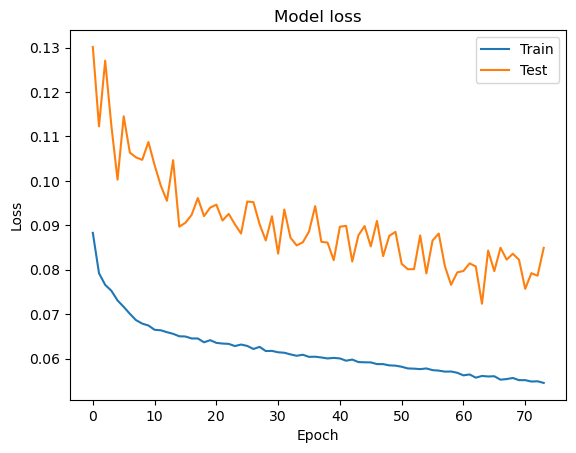

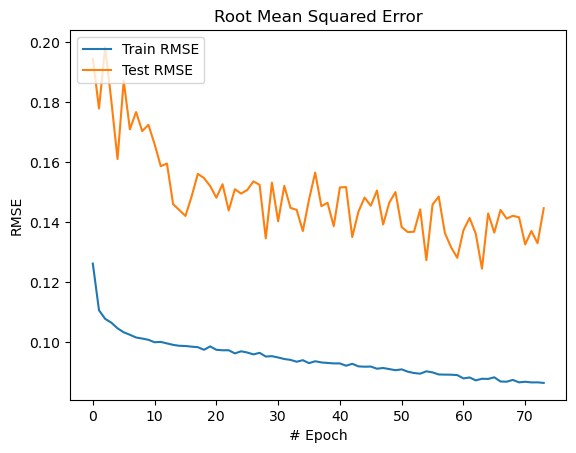

124/124 [==============================] - 1s 4ms/step - loss: 0.0566 - mse: 0.0088
Train RMSE: 0.09385301969605678
Test RMSE: 0.13881936088037045
MAE:  0.09408508852856112
RMSE:  0.1388193711418779


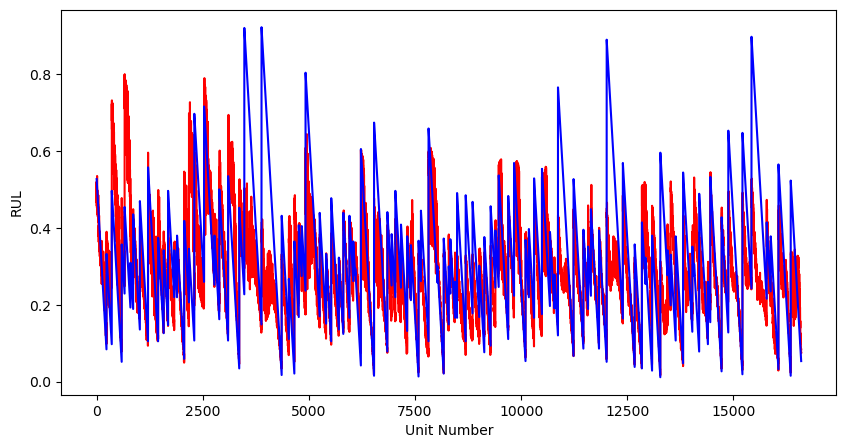

In [33]:
my_gru3(train_fd003, test_fd003)

Epoch 1/100
1723/1723 [==============================] - 20s 7ms/step - loss: 0.0991 - mse: 0.0172 - val_loss: 0.0758 - val_mse: 0.0092
Epoch 2/100
1723/1723 [==============================] - 11s 6ms/step - loss: 0.0840 - mse: 0.0130 - val_loss: 0.0745 - val_mse: 0.0097
Epoch 3/100
1723/1723 [==============================] - 11s 6ms/step - loss: 0.0801 - mse: 0.0121 - val_loss: 0.0702 - val_mse: 0.0083
Epoch 4/100
1723/1723 [==============================] - 11s 6ms/step - loss: 0.0779 - mse: 0.0116 - val_loss: 0.0702 - val_mse: 0.0079
Epoch 5/100
1723/1723 [==============================] - 11s 6ms/step - loss: 0.0773 - mse: 0.0114 - val_loss: 0.0703 - val_mse: 0.0086
Epoch 6/100
1723/1723 [==============================] - 11s 6ms/step - loss: 0.0766 - mse: 0.0113 - val_loss: 0.0905 - val_mse: 0.0122
Epoch 7/100
1723/1723 [==============================] - 11s 6ms/step - loss: 0.0765 - mse: 0.0113 - val_loss: 0.0697 - val_mse: 0.0080
Epoch 8/100
1723/1723 [=========================

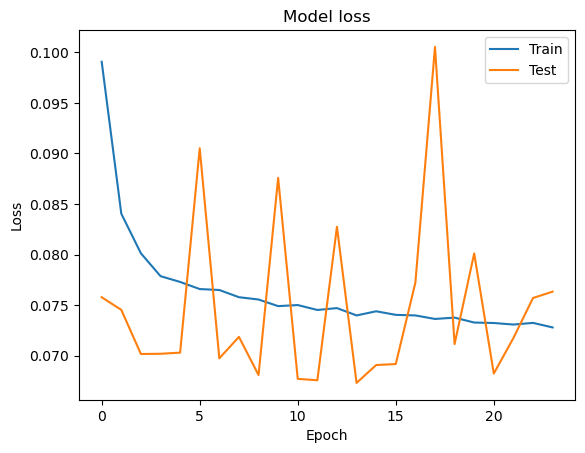

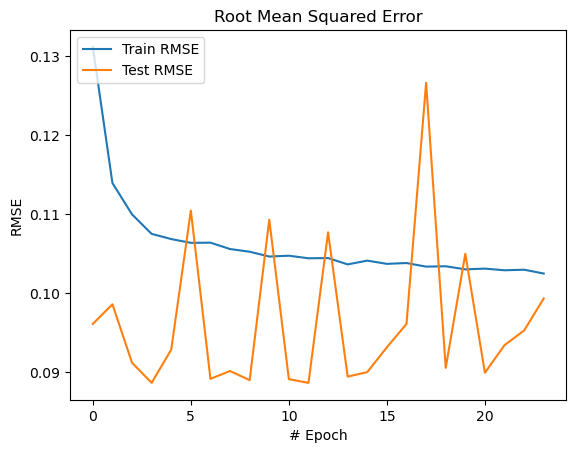

307/307 [==============================] - 1s 4ms/step - loss: 0.0709 - mse: 0.0096
Train RMSE: 0.09779809663682738
Test RMSE: 0.13438053674158626
MAE:  0.10114737475582106
RMSE:  0.13438047082740612


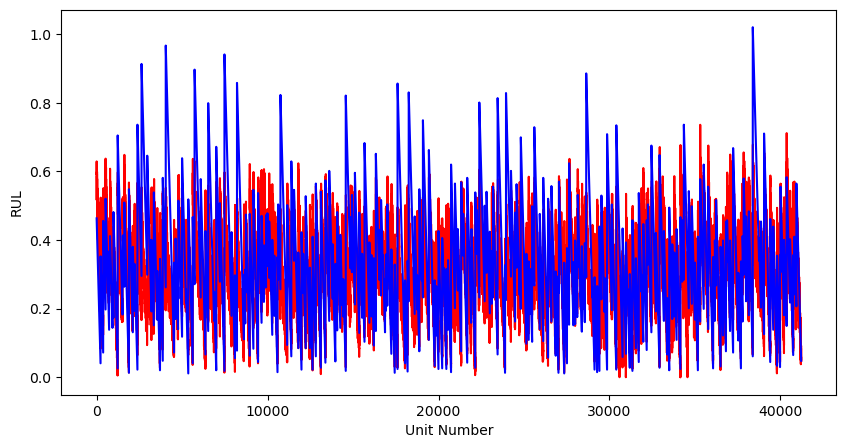

In [34]:
my_gru3(train_fd004, test_fd004)

# Two Layers Early Stopping No2

In [38]:
def my_gru4(train, test):

    # Normaliser les données
    scaler = MinMaxScaler()

    train = scaler.fit_transform(train)
    test = scaler.transform(test)

    # Préparer les données pour le modèle LSTM
    train_X = train[:,:-1]
    train_y = train[:,-1]

    test_X = test[:,:-1]
    test_y = test[:,-1]

    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

    # Créer le modèle GRU
    model = Sequential()
    model.add(GRU(units=100, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dropout(0.2))
    model.add(GRU(units=100, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.add(Activation("relu"))

    # Compiler le modèle avec une optimisation
    model.compile(loss='mae', optimizer=Adam())

    # Entraîner le modèle
    history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=0, shuffle=False)
    
    # Prédire les valeurs sur le jeu de test
    yhat = model.predict(test_X)

    # Afficher le MAE et le RMSE
    mae = mean_absolute_error(test_y, yhat)
    rmse = np.sqrt(mean_squared_error(test_y, yhat))

    print(f'MAE: {mae}')
    print(f'RMSE: {rmse}')

    # Afficher l'erreur d'entraînement et de validation sur une courbe
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Test')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    # Afficher les 200 premières valeurs prédites et réelles
    plt.figure(figsize=(10,6))
    plt.plot(yhat, label='Predicted')
    plt.plot(test_y, label='True')
    plt.title('Comparison of first 200 predicted and true values')
    plt.legend()
    plt.show()

    return model


410/410 [==============================] - 3s 3ms/step
MAE: 0.08476142827352368
RMSE: 0.11425343174143514


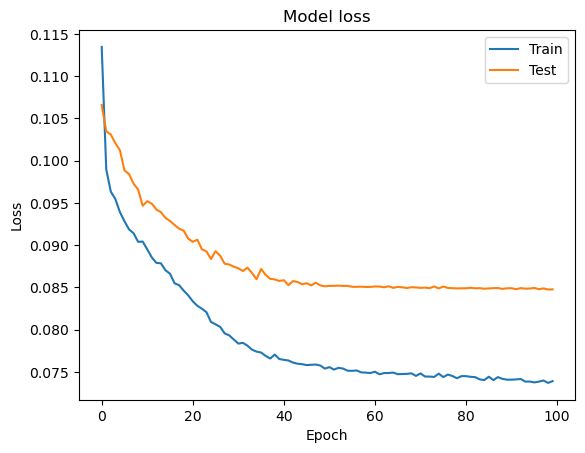

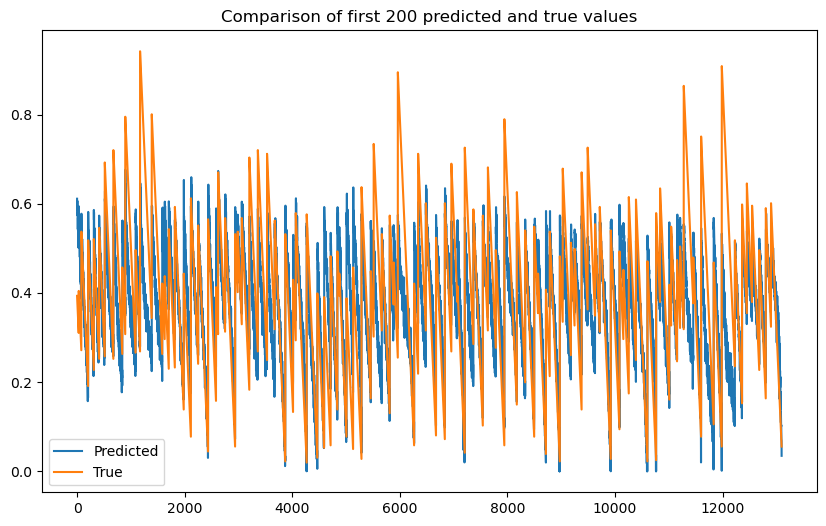

In [36]:
my_gru4(train_fd001, test_fd001)

1063/1063 [==============================] - 4s 3ms/step
MAE: 0.0969627275359752
RMSE: 0.12678385163015357


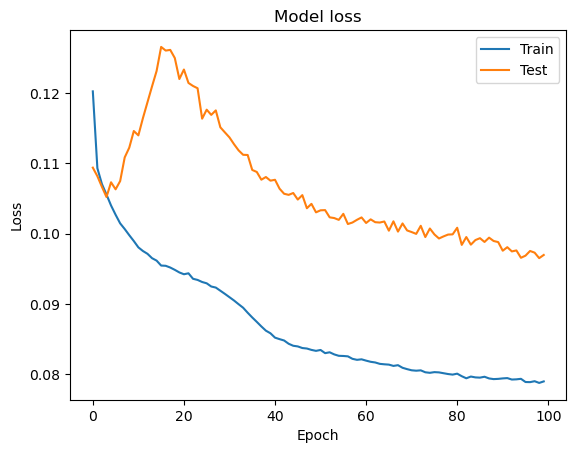

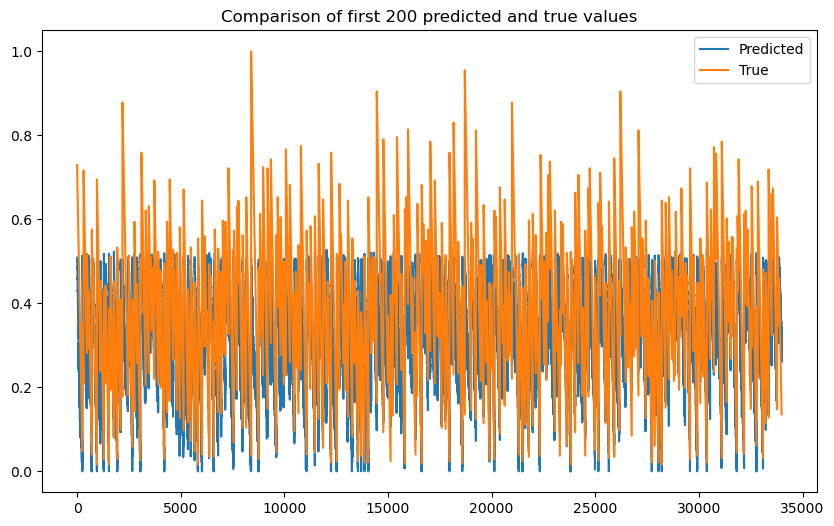

In [50]:
my_gru4(train_fd002, test_fd002)

519/519 [==============================] - 3s 3ms/step
MAE: 0.09118837823541276
RMSE: 0.12737379826818707


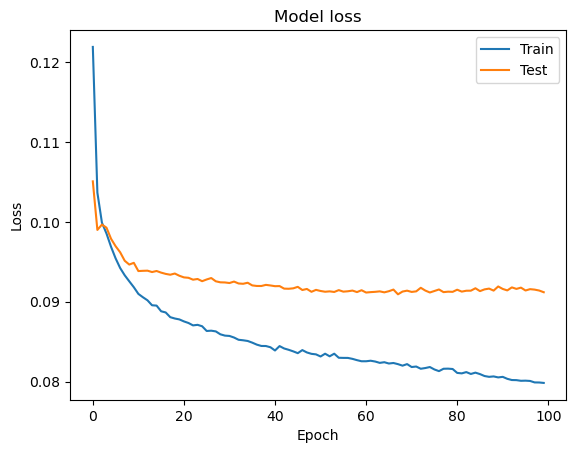

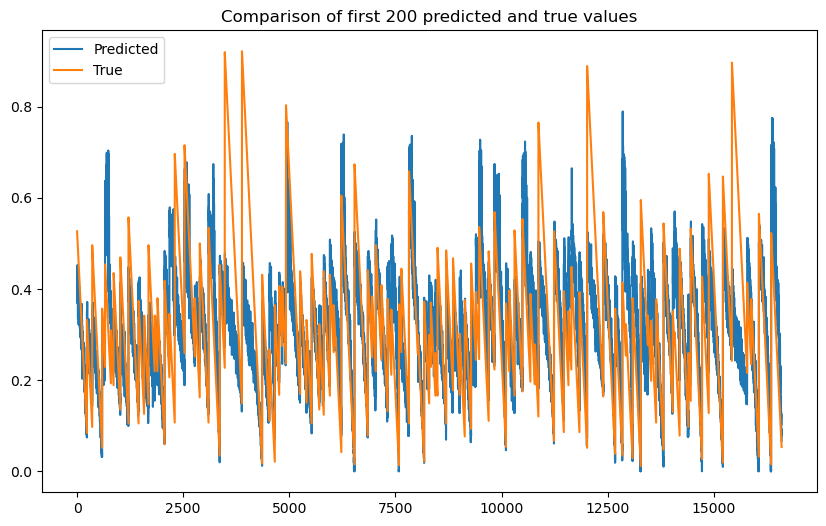

In [51]:
my_gru4(train_fd003, test_fd003)

1288/1288 [==============================] - 5s 3ms/step
MAE: 0.10641443299250082
RMSE: 0.1413764710737474


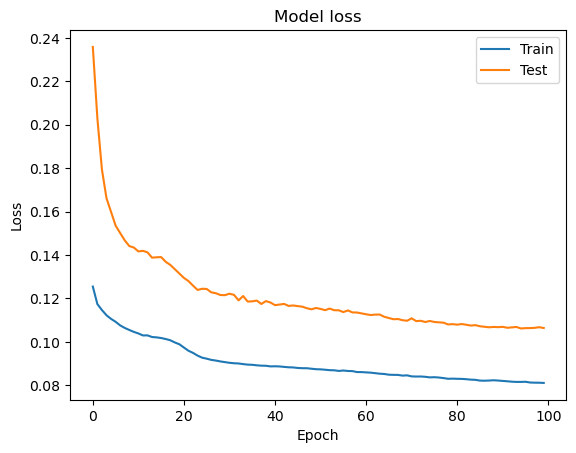

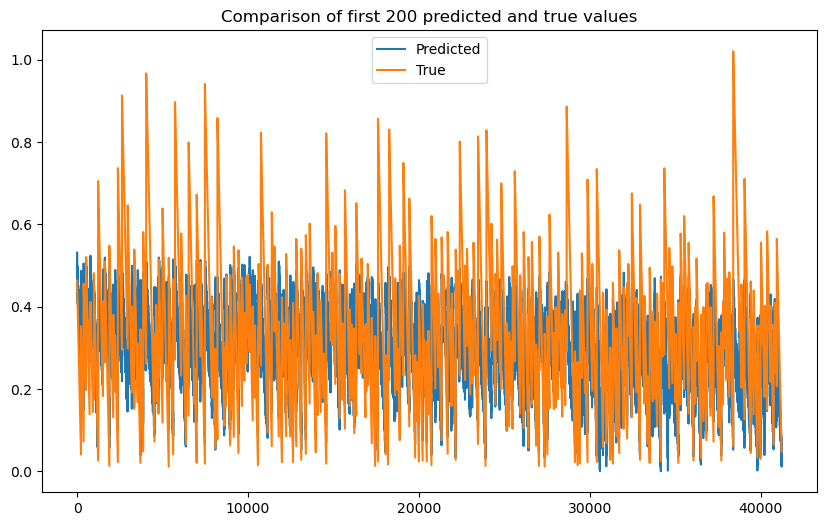

In [52]:
my_gru4(train_fd004, test_fd004)

# 2 Layers with Early Stopping and Feature Selection

In [53]:
def my_gru5(train_fd, test_fd, wich):
    
    new_train, new_test = drop_columns(train_fd, test_fd, wich)

    # Normaliser les données
    scaler = MinMaxScaler()

    train = scaler.fit_transform(new_train)
    test = scaler.transform(new_test)

    # Préparer les données pour le modèle LSTM
    train_X = train[:,:-1]
    train_y = train[:,-1]

    test_X = test[:,:-1]
    test_y = test[:,-1]

    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

    # Créer le modèle GRU
    model = Sequential()
    model.add(GRU(units=100, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dropout(0.2))
    model.add(GRU(units=100, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.add(Activation("relu"))

    # Compiler le modèle avec une optimisation
    model.compile(loss='mae', optimizer=Adam(), metrics=['mse'])

    # Entraîner le modèle
    history = model.fit(train_X, train_y, epochs=100, batch_size=32, validation_split=0.1, verbose=1,
          callbacks=[EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')])

    # Afficher l'erreur d'entraînement et de validation sur une courbe
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Test')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    
    # Calculer et afficher RMSE
    rmse_train = np.sqrt(history.history['mse'])
    rmse_test = np.sqrt(history.history['val_mse'])
    plt.plot(rmse_train, label='Train RMSE')
    plt.plot(rmse_test, label='Test RMSE')
    plt.title('Root Mean Squared Error')
    plt.ylabel('RMSE')
    plt.xlabel('# Epoch')
    plt.legend(loc='upper left')
    plt.show()

    scores = model.evaluate(train_X, train_y, verbose=1, batch_size=200)
    print('Train RMSE: {}'.format(np.sqrt(scores[1])))
    
    scores_test = model.evaluate(test_X, test_y, verbose=200)
    print('Test RMSE: {}'.format(np.sqrt(scores_test[1])))
    
    y_pred_test = model.predict(test_X, verbose=200)
    plt.figure(figsize=(10,5))
    plt.plot(y_pred_test, color='red', label='Prediction')
    plt.plot(test_y, color='blue', label='Ground Truth')
    plt.ylabel("RUL")
    plt.xlabel("Unit Number")
    plt.legend(loc='upper left')
    plt.show()

    # calculer le MAE et RMSE
    mae = mean_absolute_error(test_y, y_pred_test)
    mse = mean_squared_error(test_y, y_pred_test)
    rmse = np.sqrt(mean_squared_error(test_y, y_pred_test))
    print('MAE: ', mae)
    print('MSE: ', mse)
    print('RMSE: ', rmse)


Epoch 1/100
581/581 [==============================] - 14s 10ms/step - loss: 0.0829 - mse: 0.0130 - val_loss: 0.1329 - val_mse: 0.0262
Epoch 2/100
581/581 [==============================] - 4s 7ms/step - loss: 0.0762 - mse: 0.0110 - val_loss: 0.1303 - val_mse: 0.0255
Epoch 3/100
581/581 [==============================] - 4s 7ms/step - loss: 0.0732 - mse: 0.0105 - val_loss: 0.1219 - val_mse: 0.0266
Epoch 4/100
581/581 [==============================] - 4s 7ms/step - loss: 0.0704 - mse: 0.0100 - val_loss: 0.1225 - val_mse: 0.0229
Epoch 5/100
581/581 [==============================] - 4s 7ms/step - loss: 0.0699 - mse: 0.0099 - val_loss: 0.1161 - val_mse: 0.0225
Epoch 6/100
581/581 [==============================] - 4s 7ms/step - loss: 0.0695 - mse: 0.0099 - val_loss: 0.1169 - val_mse: 0.0224
Epoch 7/100
581/581 [==============================] - 4s 7ms/step - loss: 0.0693 - mse: 0.0098 - val_loss: 0.1161 - val_mse: 0.0228
Epoch 8/100
581/581 [==============================] - 4s 6ms/step 

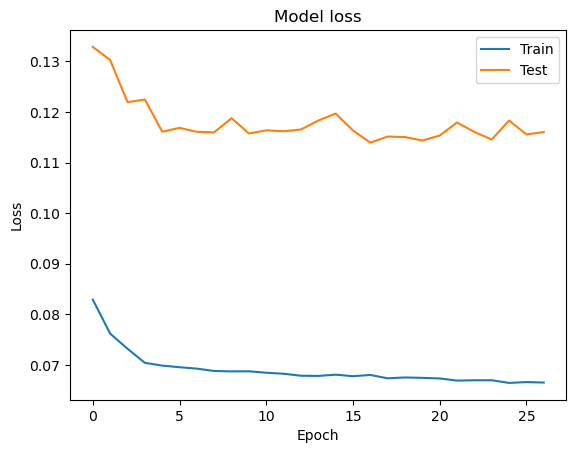

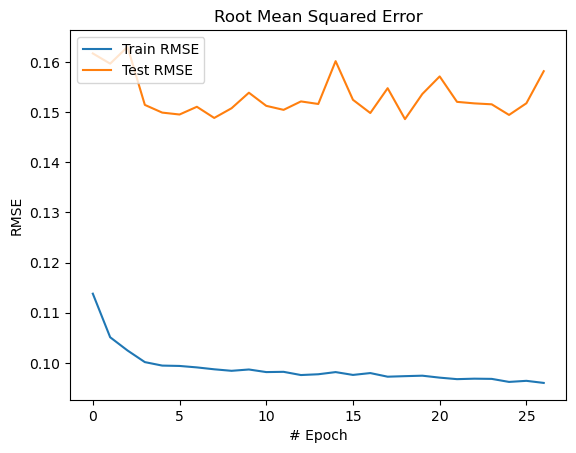

104/104 [==============================] - 0s 4ms/step - loss: 0.0714 - mse: 0.0112
Train RMSE: 0.10595915392318409
Test RMSE: 0.1231107470327846


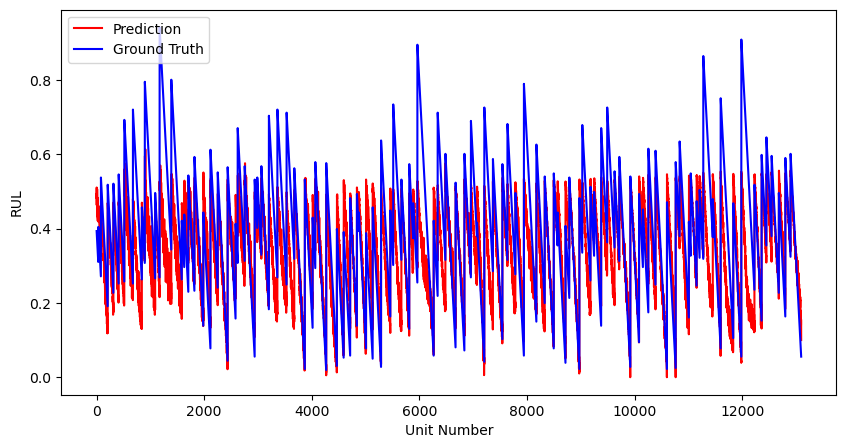

MAE:  0.08997754543395255
MSE:  0.01515625556901132
RMSE:  0.12311074514034638


In [54]:
my_gru5(train_fd001, test_fd001, 1)

In [ ]:
my_gru5(train_fd002, test_fd002, 2)

Epoch 1/100
1512/1512 [==============================] - 27s 8ms/step - loss: 0.0944 - mse: 0.0161 - val_loss: 0.1259 - val_mse: 0.0259
Epoch 2/100
1512/1512 [==============================] - 11s 7ms/step - loss: 0.0875 - mse: 0.0140 - val_loss: 0.1100 - val_mse: 0.0192
Epoch 3/100
1512/1512 [==============================] - 11s 7ms/step - loss: 0.0857 - mse: 0.0135 - val_loss: 0.1133 - val_mse: 0.0214
Epoch 4/100
1512/1512 [==============================] - 11s 7ms/step - loss: 0.0843 - mse: 0.0132 - val_loss: 0.1085 - val_mse: 0.0193
Epoch 5/100
1512/1512 [==============================] - 11s 7ms/step - loss: 0.0814 - mse: 0.0125 - val_loss: 0.1181 - val_mse: 0.0234
Epoch 6/100
1512/1512 [==============================] - 11s 7ms/step - loss: 0.0788 - mse: 0.0118 - val_loss: 0.1078 - val_mse: 0.0191
Epoch 7/100
1512/1512 [==============================] - 12s 8ms/step - loss: 0.0771 - mse: 0.0114 - val_loss: 0.1002 - val_mse: 0.0175
Epoch 8/100
1512/1512 [=========================

In [ ]:
my_gru5(train_fd003, test_fd003, 3)

In [ ]:
my_gru5(train_fd004, test_fd004, 4)